<a href="https://colab.research.google.com/github/rayshu/Data-Classification/blob/master/baseline_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import pickle

import os

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# data_path = os.path.join('D:\\Sensitive Data Detection\\data')
data_path=os.path.join('/content/drive/My Drive/Data')

congress_path = os.path.join(data_path, 'congress')
sony_path = os.path.join(data_path, 'sony')
iraq_path = os.path.join(data_path, 'iraq')

In [0]:
#function to load data
def load_data(path, train=1):
  print('Loading Data...')
  df_train = pd.read_csv(os.path.join(path, 'train.csv'))
  df_test = pd.read_csv(os.path.join(path, 'test.csv'))
  if train == 1:
    return df_train
  else:
    return df_test

In [0]:
def train_test(df):
  print('=================================================')
  print('Spliting data into training and validation set...')
  fig = plt.figure(figsize=(8,6))
  graph = df.groupby('DocType').Text.count().plot.bar(ylim=0)
    
  for p in graph.patches:
    graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
  graph.set_title('Data Distribution') 
  plt.show();
    
  Train_X, Test_X, Train_Y, Test_Y = train_test_split(df['Text'],df['DocType'],test_size=0.2)
  print('Size of Training data: ', Train_X.shape[0])
  print('Size of Validation data :  ', Test_X.shape[0])
    
  Train_counts = pd.DataFrame(Train_Y.values, columns = list('a'))
  print('\nTrain Data Distribution')
  print(Train_counts['a'].value_counts())

  Test_counts = pd.DataFrame(Test_Y.values, columns = list('a'))
  print('\n\nValidation Data Distribution')
  print(Test_counts['a'].value_counts())
    
  return Train_X, Test_X, Train_Y, Test_Y

In [0]:
def get_tfidf_features(df, Train_X, Test_X, Train_Y, Test_Y, feat=20000, N=10):
  print('=================================================')
  print('\nExtracting TF-IDF Features...')
  Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=feat, min_df=5)
    #Learn the vocabulary
  Tfidf_vect.fit(df['Text'])

  Train_X_Tfidf = Tfidf_vect.transform(Train_X)
  print("Train Data (n_samples, n_features):", Train_X_Tfidf.shape)
  Test_X_Tfidf = Tfidf_vect.transform(Test_X)
  print("Test Data (Text, Features):", Test_X_Tfidf.shape)
    
    #Get top features
  df_public = df.loc[df["DocType"]=="Public",:]
  df_private = df.loc[df["DocType"]=="Private"]
  features_public = Tfidf_vect.fit_transform(df_public.Text)
  features_private = Tfidf_vect.fit_transform(df_private.Text)
  labels_public = df_public.DocType
  labels_private = df_private.DocType
  print("Features for public train data", features_public.shape)
  print("Features for private train data", features_private.shape)

    #Public data
  features_public = Tfidf_vect.fit_transform(df_public.Text)
  feature_names = np.array(Tfidf_vect.get_feature_names())
  tfidf_sorting = np.argsort(features_public.toarray()).flatten()[::-1]
  top_public = feature_names[tfidf_sorting][:N]
  print('# Public')
  print(". {}".format('\n. '.join(top_public)))
    
    #Private data
  features_private = Tfidf_vect.fit_transform(df_private.Text)
  feature_names = np.array(Tfidf_vect.get_feature_names())
  tfidf_sorting = np.argsort(features_private.toarray()).flatten()[::-1]
  top_private = feature_names[tfidf_sorting][:N]
  print('\n# Private')
  print(". {}".format('\n. '.join(top_private)))
  return Train_X_Tfidf, Test_X_Tfidf

In [0]:
def gridSearch_RF(Train_X_Tfidf, Train_Y):
  clf = RandomForestClassifier()
  clf.fit(Train_X_Tfidf,Train_Y)
  params = {"n_estimators": [100, 300, 1000],
            "criterion": ["gini", "entropy"],
            "max_depth": [3, 10],
            "max_features": [1,3,10],
            "min_samples_split": [3,10],
            "min_samples_leaf": [1,3,10],
         }
  gs_clf = GridSearchCV(clf, param_grid=params, n_jobs=-1)
  gs_clf = gs_clf.fit(Train_X_Tfidf,Train_Y)
#     print('Best Score is: ', gs_clf.best_score_)
    # print('Best Parameters for Random Forest Classifier:\n', gs_clf.best_params_)
  return gs_clf.best_params_

def gridSearch_SVM(Train_X_Tfidf, Train_Y):
  clf = svm.SVC()
  clf.fit(Train_X_Tfidf,Train_Y)
  params = {"C": [1.0, 2.0, 3.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3, 10],
            "gamma": ['scale', 'auto'],
         }
  gs_clf = GridSearchCV(clf, param_grid=params, n_jobs=-1)
  gs_clf = gs_clf.fit(Train_X_Tfidf,Train_Y)
    # print('Best Parameters for SVM:\n', gs_clf.best_params_)
  return gs_clf.best_params_

def gridSearch_LR(Train_X_Tfidf, Train_Y):
  clf = LogisticRegression()
  clf.fit(Train_X_Tfidf,Train_Y)
  params = {"C": [1.0, 2.0, 3.0],
            "solver": ['liblinear', 'sag', 'saga', 'newton-cg', 'lbfgs'],
            "max_iter": [100, 200, 500],
            "multi_class": ['ovr',  'auto'],
            "penalty": ['l1', 'l2']
         }
  gs_clf = GridSearchCV(clf, param_grid=params, n_jobs=-1)
  gs_clf = gs_clf.fit(Train_X_Tfidf,Train_Y)
    # print('Best Parameters for Logistic Regression:\n', gs_clf.best_params_)
  return gs_clf.best_params_

In [0]:
def model_selection(Train_X_Tfidf, Train_Y):
  print('=================================================')
  print('\nHyperparameter Tuning')
  RF_params = gridSearch_RF(Train_X_Tfidf, Train_Y)
  SVM_params = gridSearch_SVM(Train_X_Tfidf, Train_Y)
  LR_params = gridSearch_LR(Train_X_Tfidf, Train_Y)
  models = [
            MultinomialNB(),
            
            svm.SVC(C=SVM_params['C'], degree=SVM_params['degree'], gamma=SVM_params['gamma'],
                    kernel=SVM_params['kernel'],random_state=0),
            
            LogisticRegression(C=LR_params['C'], max_iter=LR_params['max_iter'], 
                               multi_class=LR_params['multi_class'], solver=LR_params['solver'], random_state=0),
            
            RandomForestClassifier(criterion=RF_params['criterion'], max_depth=RF_params['max_depth'], 
                                   max_features=RF_params['max_features'], min_samples_leaf=RF_params['min_samples_leaf'],
                                   min_samples_split=RF_params['min_samples_split'], 
                                   n_estimators=RF_params['n_estimators'], random_state=0)
            ]
  CV = 5
  cv_df = pd.DataFrame(index=range(CV * len(models)))
  entries = []
  for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, Train_X_Tfidf, Train_Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
      entries.append((model_name, fold_idx, accuracy))
  cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

  sns.boxplot(x = 'model_name', y='accuracy', data=cv_df)
  sns.stripplot(x = 'model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
  plt.xticks(rotation=15)
  plt.show()
  return models, cv_df

In [0]:
def save_models(models, path):
  print('=================================================')
  print('\nSaving models with best Parameters')
  model_file_path = os.path.join(path, 'models', 'Multinomial_NB.pkl')
  model_file_pickle = open(model_file_path, 'wb')
  pickle.dump(models[0], model_file_pickle)
  model_file_pickle.close()

  model_file_path = os.path.join(path, 'models', 'SVC.pkl')
  model_file_pickle = open(model_file_path, 'wb')
  pickle.dump(models[1], model_file_pickle)
  model_file_pickle.close()

  model_file_path = os.path.join(path, 'models', 'Logistic_Regression.pkl')
  model_file_pickle = open(model_file_path, 'wb')
  pickle.dump(models[2], model_file_pickle)
  model_file_pickle.close()

  model_file_path = os.path.join(path, 'models', 'Random_Forest.pkl')
  model_file_pickle = open(model_file_path, 'wb')
  pickle.dump(models[3], model_file_pickle)
  model_file_pickle.close()

  print('Saved models successfully at', os.path.join(congress_path, 'models'))

In [0]:
def load_models(path):
  print('=================================================')
  print('\nLoading models...')
  model_file_path = os.path.join(path, 'models', 'Multinomial_NB.pkl')
  model_file_pickle = open(model_file_path, 'rb')
  NB = pickle.load(model_file_pickle)
  model_file_pickle.close()

  model_file_path = os.path.join(path, 'models', 'SVC.pkl')
  model_file_pickle = open(model_file_path, 'rb')
  SVM = pickle.load(model_file_pickle)
  model_file_pickle.close()

  model_file_path = os.path.join(path, 'models', 'Logistic_Regression.pkl')
  model_file_pickle = open(model_file_path, 'rb')
  LR = pickle.load(model_file_pickle)
  model_file_pickle.close()

  model_file_path = os.path.join(path, 'models', 'Random_Forest.pkl')
  model_file_pickle = open(model_file_path, 'rb')
  RF = pickle.load(model_file_pickle)
  model_file_pickle.close()

  models = [NB, SVM, LR, RF]
  return models

In [0]:
def run_algo(models, Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y):
  precision_public_list = []
  precision_private_list = []
  recall_public_list = []
  recall_private_list = []
  f1_public_list = []
  f1_private_list = []
  accuracy_list = []

  for model in models:   
    model_name = model.__class__.__name__
    model.fit(Train_X_Tfidf,Train_Y)
    predictions = model.predict(Test_X_Tfidf)
    conf_mat = confusion_matrix(Test_Y, predictions)
      
    print(model_name, '\n', conf_mat)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=False, yticklabels=False)
    plt.title(model_name)
    plt.xlabel("Predicted\nPrivate          Public")
    plt.ylabel("Actual\nPublic             Private")
    plt.show()
      
    True_private = conf_mat[0,0]
    False_private = conf_mat[0,1]
    False_public = conf_mat[1,0]
    True_public = conf_mat[1,1]

    precision_private = round((True_private) / (True_private + False_private), 2)
    recall_private = round((True_private) / (True_private + False_public), 2)
    f1_private = round((2 * precision_private * recall_private) / (precision_private + recall_private), 2)

    precision_public = round((True_public) / (True_public + False_public), 2)
    recall_public = round((True_public) / (True_public + False_private), 2)
    f1_public = round((2 * precision_public * recall_public)/(precision_public + recall_public), 2)

    accuracy = round((True_public + True_private) / (True_public + True_private + False_public + False_private), 2)

      #writing to list
    precision_private_list.append(precision_private)
    recall_private_list.append(recall_private)
    f1_private_list.append(f1_private)

    precision_public_list.append(precision_public)
    recall_public_list.append(recall_public)
    f1_public_list.append(f1_public)

    accuracy_list.append(accuracy)

    dict = {
        'Model':["Multinomial Naive Bayes", "Support Vector Classifier", "Logistic Regression", "Random Forest"], 
        'Accuracy': accuracy_list,
        'Precision (Public Class)': precision_public_list, 
        'Recall (Public Class)': recall_public_list,
        'F1 Score (Public Class)': f1_public_list,
        'Precision (Private Class)': precision_private_list,
        'Recall (Private Class)': recall_private_list,
        'F1 Score (Private Class)': f1_private_list
        } 
    
  evaluation_df = pd.DataFrame(dict) 
  return evaluation_df

In [0]:
def predictOnUnseenData(df_test, models, path):
  X = df_test['Text']
  Y = df_test['DocType']

  Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), max_features=20000, min_df=5)
    #Learn the vocabulary
  Tfidf_vect.fit(df_test['Text'])
  X_Tfidf = Tfidf_vect.transform(X)

  Train_counts = pd.DataFrame(Y.values, columns = list('a'))
  print('Test Data Distribution')
  print(Train_counts['a'].value_counts())

  for model in models:   
    model_name = model.__class__.__name__
    model.fit(X_Tfidf, Y)
    predictions = model.predict(X_Tfidf)
    conf_mat = confusion_matrix(Y, predictions)
      
    print(model_name, '\n', conf_mat)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=False, yticklabels=False)
    plt.title(model_name)
    plt.xlabel("Predicted\nPrivate          Public")
    plt.ylabel("Actual\nPublic             Private")
    plt.show()
      # fig.savefig('/content/drive/My Drive/Data/' + model_name + '.png')
      
    test = pd.DataFrame(X)
    test['Predicted'] = predictions
    test['Actual'] = Y
    test['match'] = np.where((test['Predicted'] != test['Actual']), 'Not Match', 'Match')
    test.loc[test["match"]=="Not Match",:]
    save_path = str(model_name) + '.csv'
    test.to_csv(os.path.join(path, save_path), index=False)

  return X_Tfidf, Y


def plot_accuracies(models, X_Tfidf, Y):
  CV = 5
  cv_df = pd.DataFrame(index=range(CV * len(models)))
  entries = []
  for model in models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, X_Tfidf, Y, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
  cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
  sns.boxplot(x='model_name', y='accuracy', data=cv_df)
  sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                size=8, jitter=True, edgecolor="gray", linewidth=2)
  plt.xticks(rotation=15)
  plt.show()

* high precision + high recall = *class pefectly handled by model*
* high precision + low recall = *class can't detect the class but highly trustable when it does*
* low precision + high recall = *well detected class but it also include points of other class*
* low precision + low recall = *class poorly handled by the model* 

# Main Function

In [0]:
def run_models(path, df_train, ParameterTune=0):
  Train_X, Test_X, Train_Y, Test_Y = train_test(df_train)
  Train_X_Tfidf, Test_X_Tfidf = get_tfidf_features(df_train, Train_X, Test_X, Train_Y, Test_Y, feat=20000, N=20)
  if ParameterTune == 1:
    model_loaded, cv_df = model_selection(Train_X_Tfidf, Train_Y)
    cv_df.groupby('model_name').accuracy.mean()
    save_models(model_loaded, path)
  else:
    model_loaded = load_models(path)
  df = run_algo(model_loaded, Train_X_Tfidf, Train_Y, Test_X_Tfidf, Test_Y)

  return df, model_loaded

def validationResults(path, df_test, model_loaded):
  X_Tfidf, Y = predictOnUnseenData(df_test, model_loaded, path)
  plot_accuracies(model_loaded, X_Tfidf, Y)

# Congress data

In [13]:
df_train = load_data(congress_path, train=1)
df_train

Loading Data...


,Text,DocType
0,bill repeal certain reporting requirement rela...,Public
1,description amendment receive pursuant provisi...,Public
2,bill directs president report congress impact ...,Public
3,art embassy act bill prohibits purchase instal...,Public
4,taxpayer fund art embassy act bill prohibits p...,Public
...,...,...
6994,trade policy eu make context legal provision p...,Private
6995,group eight g summit forum informally discus c...,Private
6996,main role berne union affiliate group prague c...,Private
6997,extradition formal surrender person state anot...,Private


In [14]:
df_test = load_data(congress_path, train=0)
df_test

Loading Data...


,Text,DocType
0,non combatant death result u strike,Public
1,terrorist target outside area active hostility...,Public
2,widely reporting generally estimate significantly,Public
3,high figure non combatant death indicate,Public
4,u government information instance period,Public
...,...,...
1742,rate long term economic growth salient measure...,Private
1743,capital offense state crime however congress r...,Private
1744,house pass h r gang deterrence community prote...,Private
1745,manufacturing seem steadily diminish presence ...,Private


Spliting data into training and validation set...


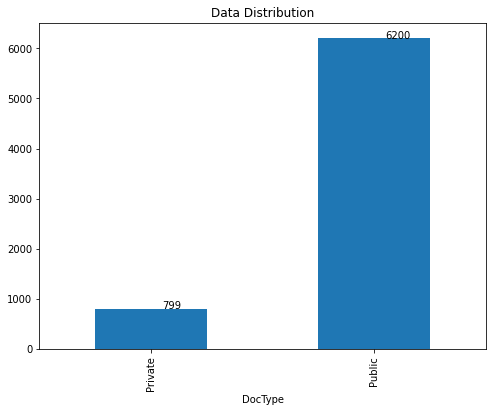

Size of Training data:  5599
Size of Validation data :   1400

Train Data Distribution
Public     4952
Private     647
Name: a, dtype: int64


Validation Data Distribution
Public     1248
Private     152
Name: a, dtype: int64

Extracting TF-IDF Features...
Train Data (n_samples, n_features): (5599, 3269)
Test Data (Text, Features): (1400, 3269)
Features for public train data (6200, 1850)
Features for private train data (799, 1761)
# Public
. report
. organization
. strike
. express
. executive branch
. exercise
. exist
. expand
. expansion
. expect
. expenditure
. explanation
. export
. export control
. export defense
. express sense
. exchange
. express support
. extend
. extraordinary

# Private
. congress approve
. legislative action
. evaluate
. commodity
. duty
. reason
. select
. approve
. procedure
. committee
. action
. legislative
. focus
. recent
. congressional
. legislation
. current
. congress
. essentially
. establish

Hyperparameter Tuning


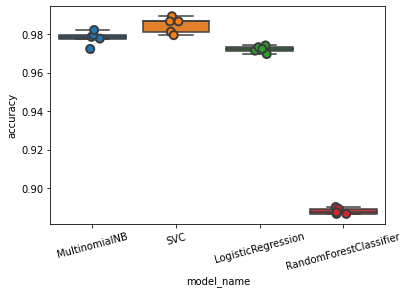


Saving models with best Parameters
Saved models successfully at /content/drive/My Drive/Data/congress/models
MultinomialNB 
 [[ 134   18]
 [   4 1244]]


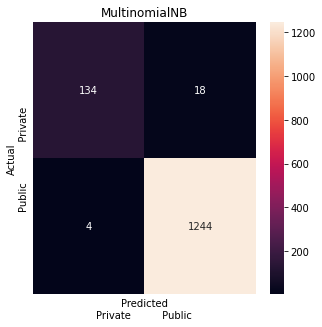

SVC 
 [[ 138   14]
 [   2 1246]]


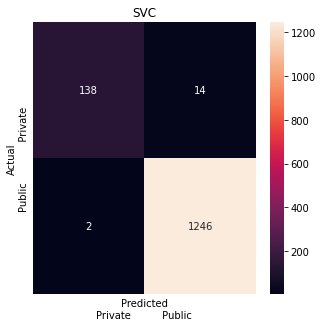

LogisticRegression 
 [[ 129   23]
 [   1 1247]]


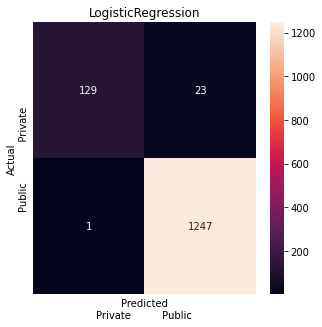

RandomForestClassifier 
 [[   4  148]
 [   0 1248]]


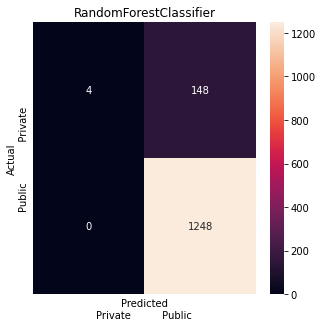

CPU times: user 23.7 s, sys: 5.67 s, total: 29.4 s
Wall time: 18min 31s


In [20]:
%%time
cong_df, model_loaded = run_models(congress_path, df_train, ParameterTune=0)

In [21]:
cong_df

,Model,Accuracy,Precision (Public Class),Recall (Public Class),F1 Score (Public Class),Precision (Private Class),Recall (Private Class),F1 Score (Private Class)
0,Multinomial Naive Bayes,0.98,1.0,0.99,0.99,0.88,0.97,0.92
1,Support Vector Classifier,0.99,1.0,0.99,0.99,0.91,0.99,0.95
2,Logistic Regression,0.98,1.0,0.98,0.99,0.85,0.99,0.91
3,Random Forest,0.89,1.0,0.89,0.94,0.03,1.00,0.06


Test Data Distribution
Public     1546
Private     201
Name: a, dtype: int64
MultinomialNB 
 [[ 178   23]
 [   0 1546]]


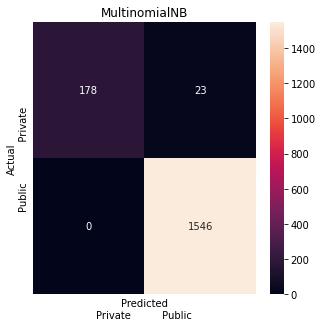

SVC 
 [[ 198    3]
 [   0 1546]]


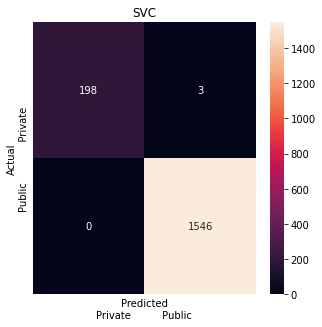

LogisticRegression 
 [[ 190   11]
 [   0 1546]]


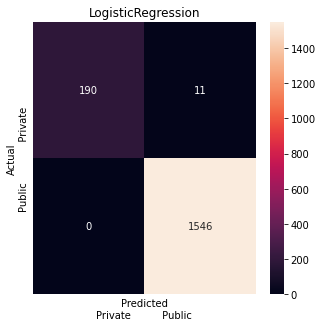

RandomForestClassifier 
 [[  98  103]
 [   0 1546]]


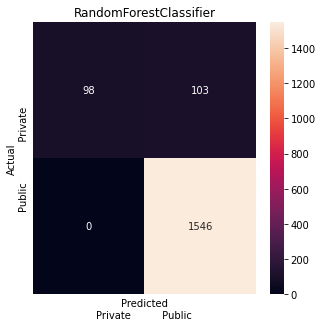

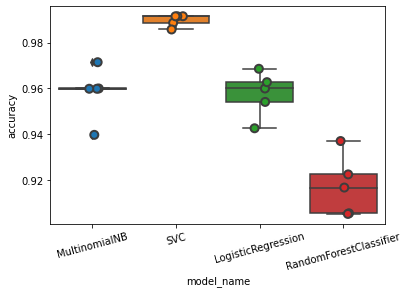

In [22]:
validationResults(congress_path, df_test, model_loaded)

# Iraq Data

In [23]:
df_train = load_data(iraq_path, train=1)
df_train

Loading Data...


,Text,DocType
0,last week dyncorp international di alliance of...,Public
1,wednesday january commissioner aaron demerson ...,Public
2,april dyncorp international di team patuxent r...,Public
3,dyncorp international alliance office donate p...,Public
4,navigate various permission license operate fo...,Public
...,...,...
1337,mnd event unit cavalry number denotes specific...,Private
1338,mnd event unit cache turn soccer timeline phon...,Private
1339,cavalry number denotes specific regiment aug t...,Private
1340,mnd event unit cavalry number denotes specific...,Private


In [24]:
df_test = load_data(iraq_path, train=0)
df_test

Loading Data...


,Text,DocType
0,dyncorp international earn champion veteran en...,Public
1,dyncorp international team member support u ai...,Public
2,u air force usaf award dyncorp international d...,Public
3,selvi sahiti domestic service supervisor qefse...,Public
4,dyncorp international parent delta tucker hold...,Public
...,...,...
339,final report engineering feb found weapon engi...,Private
340,cavalry number denotes specific regiment ia fe...,Private
341,nation report mnd event unit ia event type une...,Private
342,mnd event unit event type weapon cache feb ass...,Private


Spliting data into training and validation set...


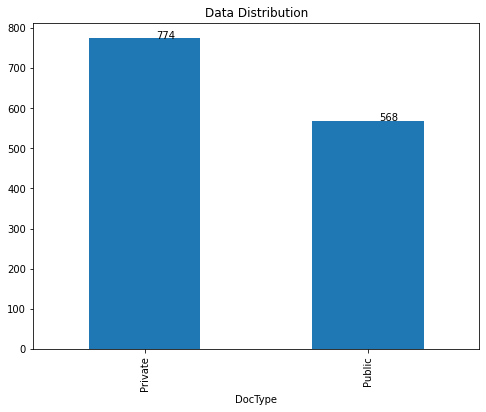

Size of Training data:  1073
Size of Validation data :   269

Train Data Distribution
Private    620
Public     453
Name: a, dtype: int64


Validation Data Distribution
Private    154
Public     115
Name: a, dtype: int64

Extracting TF-IDF Features...
Train Data (n_samples, n_features): (1073, 7235)
Test Data (Text, Features): (269, 7235)
Features for public train data (568, 4908)
Features for private train data (774, 2699)
# Public
. wing
. aircraft
. th
. boeing
. gulfstream
. joint
. th wing
. th airlift
. airlift wing
. open
. airlift
. air
. house
. support aircraft
. foreign
. show
. aircraft maintenance
. support
. angel
. assign th

# Private
. item new
. csep
. pa
. new item
. new
. item
. support cavalry
. team
. ordnance grid
. denotes
. number denotes
. cavalry
. cavalry number
. specific regiment
. specific
. denotes specific
. projectile item
. regiment
. mu
. plt

Hyperparameter Tuning


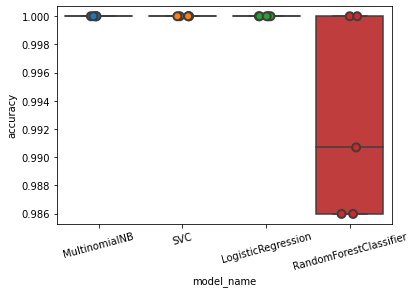


Saving models with best Parameters
Saved models successfully at /content/drive/My Drive/Data/congress/models
MultinomialNB 
 [[154   0]
 [  0 115]]


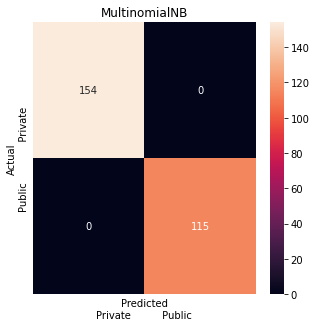

SVC 
 [[154   0]
 [  0 115]]


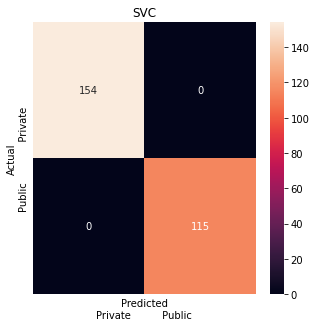

LogisticRegression 
 [[154   0]
 [  0 115]]


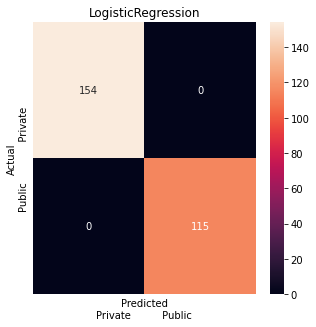

RandomForestClassifier 
 [[154   0]
 [  1 114]]


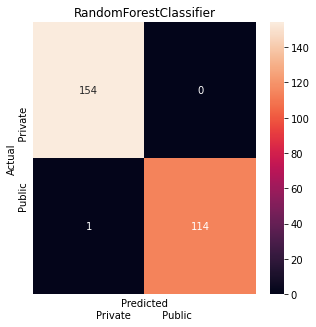

CPU times: user 31.4 s, sys: 1.71 s, total: 33.1 s
Wall time: 14min 5s


In [25]:
%%time
iraq_df, model_loaded = run_models(iraq_path, df_train, ParameterTune=0)

In [26]:
iraq_df

,Model,Accuracy,Precision (Public Class),Recall (Public Class),F1 Score (Public Class),Precision (Private Class),Recall (Private Class),F1 Score (Private Class)
0,Multinomial Naive Bayes,1.0,1.00,1.0,1.00,1.0,1.00,1.00
1,Support Vector Classifier,1.0,1.00,1.0,1.00,1.0,1.00,1.00
2,Logistic Regression,1.0,1.00,1.0,1.00,1.0,1.00,1.00
3,Random Forest,1.0,0.99,1.0,0.99,1.0,0.99,0.99


Test Data Distribution
Private    201
Public     143
Name: a, dtype: int64
MultinomialNB 
 [[201   0]
 [  0 143]]


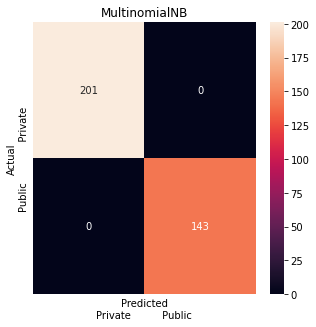

SVC 
 [[201   0]
 [  0 143]]


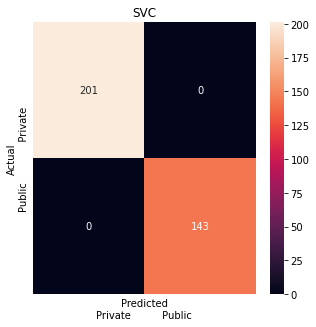

LogisticRegression 
 [[201   0]
 [  0 143]]


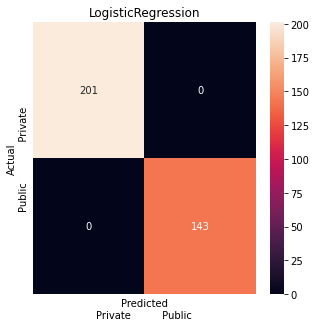

RandomForestClassifier 
 [[201   0]
 [  0 143]]


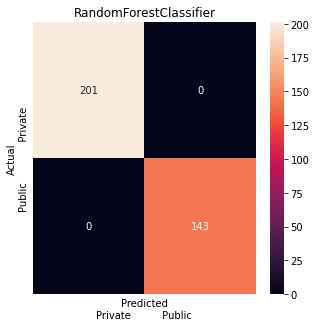

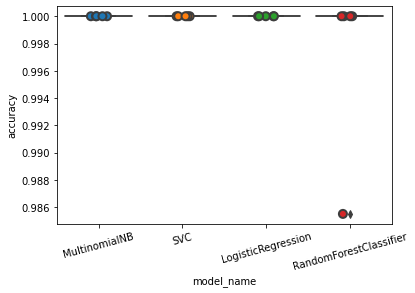

In [27]:
validationResults(iraq_path, df_test, model_loaded)

# Sony data

In [29]:
df_train = load_data(sony_path, train=1)
df_train

Loading Data...


,Text,DocType
0,digital dvd self destructive journalist pierre...,Public
1,digital blu ray dvd dave skylark james franco ...,Public
2,dvd narrate academy award nominate actor liam ...,Public
3,digital dvd chill psychological drama star chr...,Public
4,digital dvd narrate kenneth branagh glenn clos...,Public
...,...,...
1341,steve job aaron sorkin hold call ari pm michae...,Private
1342,steve job book sale everyone meaning people li...,Private
1343,leonardo dicaprio eyed steve job movie danny b...,Private
1344,dakota fan steve job amy dakota met danny boyl...,Private


In [30]:
df_test = load_data(sony_path, train=0)
df_test

Loading Data...


,Text,DocType
0,new york february sony picture classic announc...,Public
1,new york august sony picture classic announce ...,Public
2,new york may sony picture classic announce tod...,Public
3,park city ut january first purchase sundance f...,Public
4,mumbai india culver city ca june sony picture ...,Public
...,...,...
333,thewrap first take september least like fall t...,Private
334,winter reading list everything discuss read va...,Private
335,thought try onwards robert newman wme rnewman ...,Private
336,entertainment newsletter movie television cele...,Private


Spliting data into training and validation set...


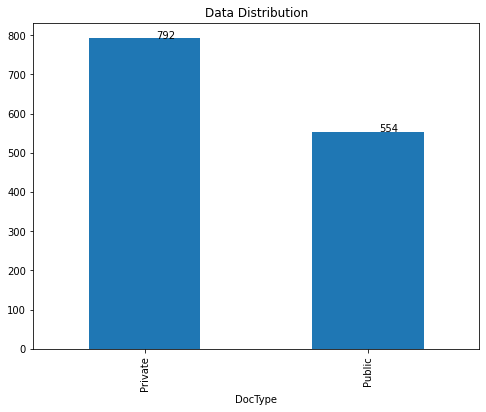

Size of Training data:  1076
Size of Validation data :   270

Train Data Distribution
Private    621
Public     455
Name: a, dtype: int64


Validation Data Distribution
Private    171
Public      99
Name: a, dtype: int64

Extracting TF-IDF Features...
Train Data (n_samples, n_features): (1076, 17352)
Test Data (Text, Features): (270, 17352)
Features for public train data (554, 3642)
Features for private train data (792, 14653)
# Public
. picture classic
. picture
. sony
. classic
. sony picture
. film
. samuel
. match
. distribution
. entertainment
. best
. official
. barker
. bernard
. soldier
. dance
. together
. america
. include best
. michael

# Private
. mar pm
. mar
. book sale
. sent ipad
. ipad
. movie think
. sale
. maybe
. keep
. write
. mil
. get little
. isaacson book
. elizabeth write
. pm cantillon
. job book
. trim
. confusion
. book
. bradley

Hyperparameter Tuning


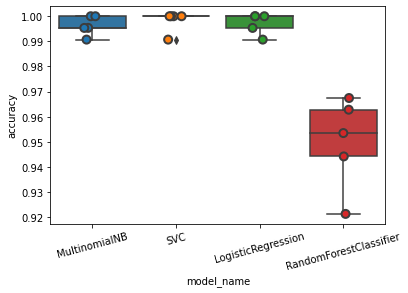


Saving models with best Parameters
Saved models successfully at /content/drive/My Drive/Data/congress/models
MultinomialNB 
 [[170   1]
 [  0  99]]


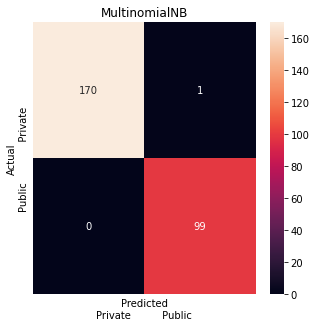

SVC 
 [[171   0]
 [  0  99]]


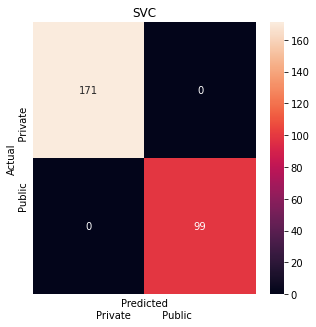

LogisticRegression 
 [[171   0]
 [  0  99]]


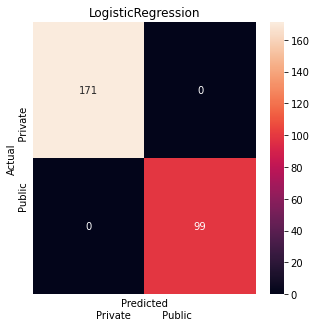

RandomForestClassifier 
 [[171   0]
 [  5  94]]


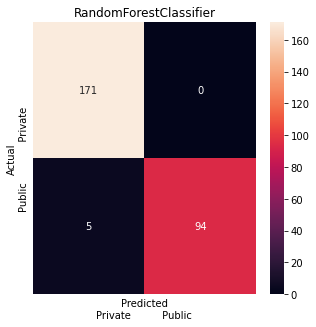

CPU times: user 44.3 s, sys: 4.83 s, total: 49.1 s
Wall time: 16min 54s


In [31]:
%%time
sony_df, model_loaded = run_models(sony_path, df_train, ParameterTune=0)

In [32]:
sony_df 

,Model,Accuracy,Precision (Public Class),Recall (Public Class),F1 Score (Public Class),Precision (Private Class),Recall (Private Class),F1 Score (Private Class)
0,Multinomial Naive Bayes,1.00,1.00,0.99,0.99,0.99,1.00,0.99
1,Support Vector Classifier,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,Logistic Regression,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,Random Forest,0.98,0.95,1.00,0.97,1.00,0.97,0.98


Test Data Distribution
Private    201
Public     137
Name: a, dtype: int64
MultinomialNB 
 [[199   2]
 [  0 137]]


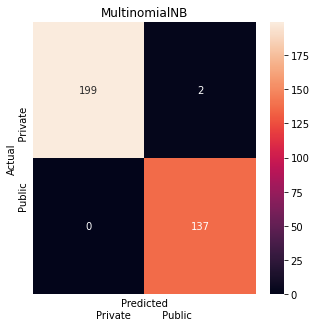

SVC 
 [[201   0]
 [  0 137]]


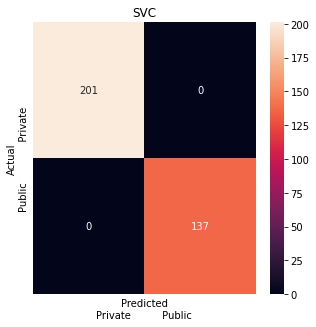

LogisticRegression 
 [[201   0]
 [  0 137]]


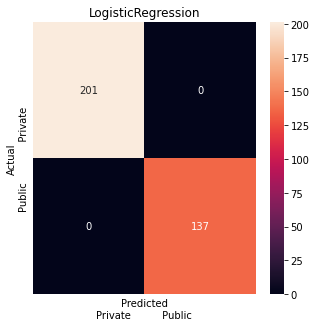

RandomForestClassifier 
 [[201   0]
 [  0 137]]


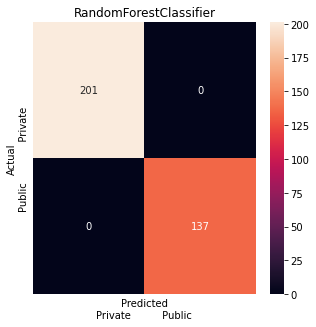

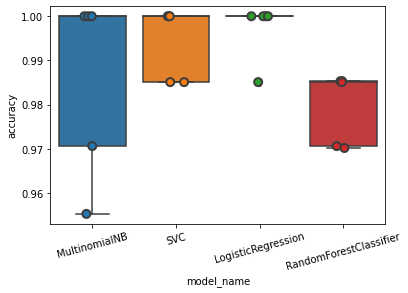

In [33]:
validationResults(sony_path, df_test, model_loaded)

In [37]:
df = pd.DataFrame(cong_df['Model'])
df['Congress'] = cong_df['Accuracy']
df['Iraq'] = iraq_df['Accuracy']
df['Sony'] = sony_df['Accuracy']
df

,Model,Congress,Iraq,Sony
0,Multinomial Naive Bayes,0.98,1.0,1.00
1,Support Vector Classifier,0.99,1.0,1.00
2,Logistic Regression,0.98,1.0,1.00
3,Random Forest,0.89,1.0,0.98
